In [23]:
import csv
import itertools
from matplotlib import pyplot as plt
import numpy as np
import random

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# import warnings
# warnings.filterwarnings("ignore")

### Read the data

In [38]:
with open('creditcard.csv', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    csv_data = list(reader)[1:]
    
csv_data = [row for row in csv_data if int(row[-1]) == 1 or random.random() < .05]

# Format: Time, V1, ..., V28, Amount, Class
data = np.array([[float(x) for x in row[1:-1]] for row in csv_data])
times = np.array([float(row[0]) for row in csv_data])
labels = np.array([int(row[-1]) for row in csv_data])
print('The data is imbalanced, with {} samples in total but only {} cases of fraud'.format(len(labels), sum(labels)))

The data is imbalanced, with 14613 samples in total but only 492 cases of fraud


### Feature Scaling

In [39]:
print(np.mean(data, axis=0))
print(np.var(data, axis=0))
print('The PCA features have mean 0 but different variances')
print('The transaction amount is not scaled. We should scale it so it does not affect the SVM too much')

[-1.36138071e-01  1.08747932e-01 -2.31636452e-01  1.43066709e-01
 -8.71082980e-02 -5.13922332e-02 -1.64526465e-01  7.89883117e-03
 -9.76343425e-02 -1.88949167e-01  1.24586302e-01 -1.87390859e-01
 -1.01443419e-02 -2.29775306e-01  7.81853052e-03 -1.31768137e-01
 -2.22835738e-01 -8.47656214e-02  2.94615613e-02  1.32879422e-02
  3.18184249e-02  1.20779615e-02 -5.21694121e-03 -6.69735803e-03
 -3.74077645e-03  1.01309416e-03  5.11590009e-03 -1.09001717e-03
  9.11537166e+01]
[5.84373454e+00 3.85842725e+00 5.38963903e+00 2.86785646e+00
 3.09604938e+00 1.88607838e+00 4.11254513e+00 2.86731019e+00
 1.53335185e+00 2.90503745e+00 1.66953850e+00 2.84290350e+00
 9.88577657e-01 2.95215138e+00 8.32541491e-01 1.75163967e+00
 3.63238363e+00 1.11950579e+00 7.37049834e-01 7.38136345e-01
 1.08624144e+00 6.02125068e-01 4.17537170e-01 3.67978125e-01
 2.84038369e-01 2.25896809e-01 2.19285145e-01 8.80268571e-02
 8.66798281e+04]
The PCA features have mean 0 but different variances
The transaction amount is not 

In [40]:
scaler = StandardScaler()
data_sc = scaler.fit_transform(data)
print(np.mean(data_sc, axis=0))
print(np.var(data_sc, axis=0))

[ 5.89338261e-16  4.03293471e-16  9.97119007e-16 -5.79879370e-16
 -4.76211450e-16 -1.81428357e-17 -1.57786829e-16 -2.39646119e-16
  3.56482410e-16  1.30526990e-15  1.23003564e-15  5.80259245e-16
 -2.09903796e-16  6.21574463e-16 -3.82640610e-16 -4.71045148e-19
 -8.53190022e-17  4.85434818e-16 -6.33631700e-18  2.04657721e-17
 -1.95960480e-16 -3.43255158e-17  1.72477550e-17 -2.96302593e-18
 -3.45321679e-16  7.94698750e-17 -1.42871032e-17  1.57553206e-17
  6.48917684e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


### Preliminary plotting

[ 1.06937359  0.24749113  1.23742903 -0.93573151 -1.16942246  0.15833178
  1.110692    1.14736893  1.15693907]


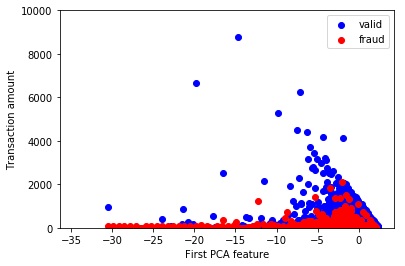

In [41]:
# plot the first two principal components
data_fraud = data[np.where(labels == 1)]
data_valid = data[np.where(labels == 0)]
plt.scatter(data_valid[:, 0], data_valid[:, -1], c='b')
plt.scatter(data_fraud[:, 0], data_fraud[:, -1], c='r')
print(data_valid[1:10, 0])
plt.ylim((0, 10000))
plt.legend(['valid', 'fraud'])
plt.xlabel('First PCA feature')
plt.ylabel('Transaction amount')
plt.show()

### Setting up cross-validation

In [42]:
fraud_indices = np.where(labels == 1)[0]
np.random.shuffle(fraud_indices)
fraud_splits = np.array_split(fraud_indices, 5)

valid_indices = np.where(labels == 0)[0]
np.random.shuffle(valid_indices)
valid_splits = np.array_split(valid_indices, 5)

folds = [np.concatenate((fraud_sp, valid_sp)) for fraud_sp, valid_sp in zip(fraud_splits, valid_splits)]

### SVM

In [6]:
def train_binary_SVM(data, scale=False, kernel=None, class_weight=None):
    confusion_mat = np.zeros((2, 2))
    for i in range(5):
        if kernel is None:
            if class_weight is None:
                svm = LinearSVC(fit_intercept=False, dual=False)
            else:
                svm = LinearSVC(fit_intercept=False, dual=False, class_weight=class_weight)
        else:
            if class_weight is None:
                svm = SVC(kernel=kernel, gamma='auto')
            else:
                svm = SVC(kernel=kernel, gamma='auto', class_weight=class_weight)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        svm.fit(train_data, np.delete(labels, folds[i]))
        pred = svm.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        print('Fold', i)
        print(conf_mat)

        confusion_mat += conf_mat

    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    print('False negatives (valid):', confusion_mat[0, 1] / sum(confusion_mat[0, :]))
    print('False positives (fraud):', confusion_mat[1, 0] / sum(confusion_mat[1,:]))
    return confusion_mat

#### Linear SVM -- Without scaling or class weights

In [7]:
train_binary_SVM(data);

Fold 0
[[56819    44]
 [   33    66]]
Fold 1
[[56829    34]
 [   39    60]]
Fold 2
[[56824    39]
 [   29    69]]
Fold 3
[[56820    43]
 [   38    60]]
Fold 4
[[56829    34]
 [   34    64]]
Final Confusion Matrix
[[5.68242e+04 3.88000e+01]
 [3.46000e+01 6.38000e+01]]
False negatives (valid): 0.0006823417688127605
False positives (fraud): 0.3516260162601626


#### Linear SVM with Scaling

In [8]:
train_binary_SVM(data, scale=True);

Fold 0
[[48725  8138]
 [    5    94]]
Fold 1
[[49241  7622]
 [    2    97]]
Fold 2
[[49706  7157]
 [    2    96]]
Fold 3
[[50615  6248]
 [    7    91]]
Fold 4
[[48501  8362]
 [    5    93]]
Final Confusion Matrix
[[4.93576e+04 7.50540e+03]
 [4.20000e+00 9.42000e+01]]
False negatives (valid): 0.1319909255579199
False positives (fraud): 0.04268292682926829


#### Linear SVM with Scaling and Class Weights

In [9]:
train_binary_SVM(data, scale=True, class_weight='balanced');

Fold 0
[[34211 22652]
 [    3    96]]
Fold 1
[[34100 22763]
 [    0    99]]
Fold 1
[[34254 22609]
 [    1    98]]
Fold 2
[[33983 22880]
 [    0    98]]
Fold 3
[[33339 23524]
 [    1    97]]
Fold 3
[[33377 23486]
 [    3    95]]
Fold 4
[[34100 22763]
 [    1    97]]
Final Confusion Matrix
[[3.39466e+04 2.29164e+04]
 [1.00000e+00 9.74000e+01]]
False negatives (valid): 0.403010745124246
False positives (fraud): 0.01016260162601626


### Kernel SVM

#### RBF Kernel with Scaling and Class Weights

In [11]:
train_binary_SVM(data, scale=True, kernel='rbf');

Fold 0
[[56859     4]
 [   34    65]]
Fold 1
[[56861     2]
 [   35    64]]
Fold 2
[[56859     4]
 [   27    71]]
Fold 3
[[56861     2]
 [   35    63]]
Fold 4
[[56859     4]
 [   34    64]]
Final Confusion Matrix
[[5.68598e+04 3.20000e+00]
 [3.30000e+01 6.54000e+01]]
False negatives (valid): 5.627560979899056e-05
False positives (fraud): 0.33536585365853655


In [12]:
train_binary_SVM(data, kernel='rbf', class_weight='balanced');

Fold 0
[[56792    71]
 [   54    45]]
Fold 1
[[56790    73]
 [   49    50]]
Fold 2
[[56815    48]
 [   57    41]]
Fold 3
[[56809    54]
 [   55    43]]
Fold 4
[[56804    59]
 [   52    46]]
Final Confusion Matrix
[[5.6802e+04 6.1000e+01]
 [5.3400e+01 4.5000e+01]]
False negatives (valid): 0.0010727538117932575
False positives (fraud): 0.5426829268292682


#### Polynomial Kernel with Scaling and Class Weights

In [13]:
train_binary_SVM(data, scale=True, kernel='poly');

Fold 0
[[56858     5]
 [   22    77]]
Fold 1
[[56855     8]
 [   30    69]]
Fold 2
[[56853    10]
 [   22    76]]
Fold 3
[[56858     5]
 [   19    79]]
Fold 4
[[56858     5]
 [   32    66]]
Final Confusion Matrix
[[5.68564e+04 6.60000e+00]
 [2.50000e+01 7.34000e+01]]
False negatives (valid): 0.00011606844521041801
False positives (fraud): 0.25406504065040647


In [14]:
train_binary_SVM(data, scale=True, kernel='poly', class_weight='balanced');

Fold 0
[[56590   273]
 [   22    77]]
Fold 1
[[56624   239]
 [   25    74]]
Fold 2
[[56684   179]
 [   21    77]]
Fold 3
[[56610   253]
 [   22    76]]
Fold 4
[[56678   185]
 [   28    70]]
Final Confusion Matrix
[[5.66372e+04 2.25800e+02]
 [2.36000e+01 7.48000e+01]]
False negatives (valid): 0.003970947716441272
False positives (fraud): 0.23983739837398374


### Logistic Regression

In [ ]:
def train_logistic_regression(data, class_weight = None, C=1.0):
    err = 0
    err_valid = 0
    err_fraud = 0
    confusion_mat = np.zeros((2, 2))
    AU = 0
    for i in range(5):
        model = LogisticRegression(class_weight=class_weight, C=C)
        
        model.fit(np.delete(data, folds[i], axis=0), np.delete(labels, folds[i]))
        pred = model.predict(data[folds[i]])
        pred1 = model.predict_proba(data[folds[i]])[:,1]
        #err_fold = np.sum((pred - labels[folds[i]])**2) / len(folds[i])
        #pred_valid = model.predict(data[valid_splits[i]])
        #err_valid_fold = np.sum((pred_valid - labels[valid_splits[i]])**2) / len(valid_splits[i])
        #pred_fraud = model.predict(data[fraud_splits[i]])
        #err_fraud_fold = np.sum((pred_fraud - labels[fraud_splits[i]])**2) / len(fraud_splits[i])
        #print('Fold', i, 'Error:', err_fold, 'Valid Error:', err_valid_fold, 'Fraud Error', err_fraud_fold)
        #err += err_fold
        #err_valid += err_valid_fold
        #err_fraud += err_fraud_fold
        conf_mat = confusion_matrix(labels[folds[i]], pred)
        fpr, tpr, thresholds = roc_curve(labels[folds[i]], pred1)
        area_under_curve = auc(fpr, tpr)
        AU += area_under_curve
        print('Fold', i)
        print(conf_mat)
        print('Area under curve:', area_under_curve)

        confusion_mat += conf_mat
    AU/=5
    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    return confusion_mat, AU
    #err /= 5
    #err_valid /= 5
    #err_fraud /= 5
    #print('FINAL Error:', err, 'Valid Error:', err_valid, 'Fraud Error', err_fraud)
    #return err, err_valid, err_fraud

#### Logistic Regression with Scaling, Class Weights, and Regularization

In [16]:
weights = [None,'balanced']
coefficients = np.logspace(-2,0,10)
fraud_errs = []
param_permuations = list(itertools.product(weights, coefficients))
for cw,C in param_permuations:
    print('Checking class weight {} and coefficient {}'.format(cw, C))
    _,_,fe = train_logistic_regression(data, cw, C)
    fraud_errs.append(fe)

idx = np.argmin(fraud_errs)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

Checking class weight None and coefficient 0.01


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.0007548892243952109 Valid Error: 0.23282274941526124 Fraud Error 0.20202020202020202


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.0008426670411853516 Valid Error: 0.1856391678244201 Fraud Error 0.23232323232323232


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.0009304611927459139 Valid Error: 0.18356400471308232 Fraud Error 0.21428571428571427


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.000772458348694721 Valid Error: 0.17081406186799852 Fraud Error 0.20408163265306123


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.0009129053211846702 Valid Error: 0.1705150976909414 Fraud Error 0.25510204081632654
FINAL Error: 0.0008426762256411735 Valid Error: 0.18867101630234073 Fraud Error 0.2215625644197073
Checking class weight None and coefficient 0.016681005372000592


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.0007548892243952109 Valid Error: 0.2625608919684153 Fraud Error 0.1919191919191919


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.0008426670411853516 Valid Error: 0.2023635756115576 Fraud Error 0.2222222222222222


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.0009304611927459139 Valid Error: 0.19559291630761655 Fraud Error 0.21428571428571427


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.000772458348694721 Valid Error: 0.19128431493238135 Fraud Error 0.19387755102040816


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.0009129053211846702 Valid Error: 0.18154159998593108 Fraud Error 0.24489795918367346
FINAL Error: 0.0008426762256411735 Valid Error: 0.20666865976118037 Fraud Error 0.21344052772624203
Checking class weight None and coefficient 0.027825594022071243


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.0007548892243952109 Valid Error: 0.2938641999191038 Fraud Error 0.18181818181818182


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.0008426670411853516 Valid Error: 0.23000896892531172 Fraud Error 0.21212121212121213


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000877793578062183 Valid Error: 0.20855389268944657 Fraud Error 0.19387755102040816


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.000772458348694721 Valid Error: 0.22246451998663455 Fraud Error 0.1836734693877551


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.0009129053211846702 Valid Error: 0.20083358247014754 Fraud Error 0.22448979591836735
FINAL Error: 0.0008321427027044272 Valid Error: 0.2311450327981288 Fraud Error 0.19919604205318492
Checking class weight None and coefficient 0.046415888336127774


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.0007373336610371826 Valid Error: 0.3290540421715351 Fraud Error 0.18181818181818182


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.0008602226045433798 Valid Error: 0.260819865290259 Fraud Error 0.18181818181818182


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.0008953494496234265 Valid Error: 0.22793380581397393 Fraud Error 0.1836734693877551


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.0007549024771334773 Valid Error: 0.26504053602518335 Fraud Error 0.15306122448979592


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.0009304611927459139 Valid Error: 0.23452860383729315 Fraud Error 0.1836734693877551
FINAL Error: 0.0008356538770166761 Valid Error: 0.2634753706276489 Fraud Error 0.17680890538033395
Checking class weight None and coefficient 0.0774263682681127


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.0007373336610371826 Valid Error: 0.36939661994618644 Fraud Error 0.16161616161616163


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.0008602226045433798 Valid Error: 0.2926331709547509 Fraud Error 0.18181818181818182


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000877793578062183 Valid Error: 0.2523609376923483 Fraud Error 0.1836734693877551


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.0007549024771334773 Valid Error: 0.3089706839245203 Fraud Error 0.14285714285714285


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.0009304611927459139 Valid Error: 0.27432601164201675 Fraud Error 0.1836734693877551
FINAL Error: 0.0008321427027044272 Valid Error: 0.2995374848319646 Fraud Error 0.17072768501339927
Checking class weight None and coefficient 0.1291549665014884


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.0007197780976791545 Valid Error: 0.39793890579111196 Fraud Error 0.15151515151515152


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.0008602226045433798 Valid Error: 0.32245924414821586 Fraud Error 0.16161616161616163


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.0008602377065009393 Valid Error: 0.2809559819214604 Fraud Error 0.1836734693877551


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.000772458348694721 Valid Error: 0.34913740041854985 Fraud Error 0.1326530612244898


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.0008953494496234265 Valid Error: 0.3101665406327489 Fraud Error 0.1836734693877551
FINAL Error: 0.0008216092414083242 Valid Error: 0.3321316145824174 Fraud Error 0.16262626262626262
Checking class weight None and coefficient 0.21544346900318834


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.0007197780976791545 Valid Error: 0.41673847668958724 Fraud Error 0.15151515151515152


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.0008602226045433798 Valid Error: 0.34831085239962717 Fraud Error 0.1414141414141414


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000877793578062183 Valid Error: 0.30747586303923463 Fraud Error 0.1836734693877551


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.000772458348694721 Valid Error: 0.37688831050067706 Fraud Error 0.12244897959183673


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.0008953494496234265 Valid Error: 0.3378998645868139 Fraud Error 0.17346938775510204
FINAL Error: 0.0008251204157205729 Valid Error: 0.357462673443188 Fraud Error 0.15450422593279736
Checking class weight None and coefficient 0.3593813663804626


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.0007197780976791545 Valid Error: 0.42787049575295005 Fraud Error 0.1414141414141414


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.0008602226045433798 Valid Error: 0.3662487030230554 Fraud Error 0.1414141414141414


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000877793578062183 Valid Error: 0.32766473805462254 Fraud Error 0.1836734693877551


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.0007549024771334773 Valid Error: 0.3938061656964986 Fraud Error 0.12244897959183673


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.0009129053211846702 Valid Error: 0.3574908112480875 Fraud Error 0.17346938775510204
FINAL Error: 0.0008251204157205729 Valid Error: 0.3746161827550428 Fraud Error 0.15248402391259536
Checking class weight None and coefficient 0.5994842503189409


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.0007197780976791545 Valid Error: 0.434342190879834 Fraud Error 0.13131313131313133


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.0008426670411853516 Valid Error: 0.3773279637022317 Fraud Error 0.1414141414141414


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000877793578062183 Valid Error: 0.34444190422594656 Fraud Error 0.17346938775510204


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.0007549024771334773 Valid Error: 0.4030037106730211 Fraud Error 0.11224489795918367


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.0009129053211846702 Valid Error: 0.36893938061656967 Fraud Error 0.17346938775510204
FINAL Error: 0.0008216093030489673 Valid Error: 0.38561103001952063 Fraud Error 0.14638218923933208
Checking class weight None and coefficient 1.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.0007022225343211264 Valid Error: 0.43699769621722384 Fraud Error 0.13131313131313133


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.0008426670411853516 Valid Error: 0.384889998768971 Fraud Error 0.1414141414141414


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.000877793578062183 Valid Error: 0.35423737755658335 Fraud Error 0.16326530612244897


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.0007549024771334773 Valid Error: 0.4080333432988059 Fraud Error 0.11224489795918367


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.0009129053211846702 Valid Error: 0.3751121115663964 Fraud Error 0.17346938775510204
FINAL Error: 0.0008180981903773617 Valid Error: 0.39185410548159616 Fraud Error 0.14434137291280147
Checking class weight balanced and coefficient 0.01


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.025244900108844493 Valid Error: 0.8464027575048801 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.02291001018222675 Valid Error: 0.8212897666320806 Fraud Error 0.010101010101010102


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.023963764681097594 Valid Error: 0.8289573184671931 Fraud Error 0.02040816326530612


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.02145327504783975 Valid Error: 0.7909361095967501 Fraud Error 0.01020408163265306


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.021154825231298607 Valid Error: 0.8129539419306051 Fraud Error 0.01020408163265306
FINAL Error: 0.02294535505026144 Valid Error: 0.8201079788263017 Fraud Error 0.010183467326324467
Checking class weight balanced and coefficient 0.016681005372000592


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.02536778905235069 Valid Error: 0.8720257460914831 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.023015343562374918 Valid Error: 0.8479503367743524 Fraud Error 0.010101010101010102


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.024033988167342566 Valid Error: 0.8538065174190599 Fraud Error 0.02040816326530612


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.021523498534084723 Valid Error: 0.8089618908604892 Fraud Error 0.01020408163265306


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.0213128280753498 Valid Error: 0.8319821324938889 Fraud Error 0.01020408163265306
FINAL Error: 0.02305068947830054 Valid Error: 0.8429453247278547 Fraud Error 0.010183467326324467
Checking class weight balanced and coefficient 0.027825594022071243


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.025508233559214916 Valid Error: 0.8953801241580641 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.022962676872300834 Valid Error: 0.8730105692629654 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.02413932339671003 Valid Error: 0.8836853489967114 Fraud Error 0.02040816326530612


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.021663945506574675 Valid Error: 0.8292738687723124 Fraud Error 0.01020408163265306


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.02155861027720721 Valid Error: 0.851063081441359 Fraud Error 0.01020408163265306
FINAL Error: 0.02316655792240153 Valid Error: 0.8664825985262825 Fraud Error 0.008163265306122448
Checking class weight balanced and coefficient 0.046415888336127774


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.02545556686914083 Valid Error: 0.9120693596890772 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.023208454759313227 Valid Error: 0.8915639343685701 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.024209546882955003 Valid Error: 0.9080245502347748 Fraud Error 0.01020408163265306


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.02164638963501343 Valid Error: 0.8488120570493994 Fraud Error 0.01020408163265306


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.02164638963501343 Valid Error: 0.8671543886182579 Fraud Error 0.01020408163265306
FINAL Error: 0.023233269556287184 Valid Error: 0.885524857992016 Fraud Error 0.006122448979591836
Checking class weight balanced and coefficient 0.0774263682681127


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.025490677995856886 Valid Error: 0.9226737949105746 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.023243565886029282 Valid Error: 0.903944568524348 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.02424465862607749 Valid Error: 0.9274220494873644 Fraud Error 0.01020408163265306


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.02155861027720721 Valid Error: 0.8663805989835218 Fraud Error 0.01020408163265306


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.02161127789189094 Valid Error: 0.8816629442695602 Fraud Error 0.01020408163265306
FINAL Error: 0.023229758135412358 Valid Error: 0.9004167912350738 Fraud Error 0.006122448979591836
Checking class weight balanced and coefficient 0.1291549665014884


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.02545556686914083 Valid Error: 0.9295323848548265 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.023296232576103366 Valid Error: 0.9122452209696991 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.02433243798388371 Valid Error: 0.9428802560540246 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.0215937220203297 Valid Error: 0.8798867453352796 Fraud Error 0.01020408163265306


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.021681501378135917 Valid Error: 0.8921618627226844 Fraud Error 0.01020408163265306
FINAL Error: 0.023271892165518705 Valid Error: 0.9113412939873028 Fraud Error 0.004081632653061224
Checking class weight balanced and coefficient 0.21544346900318834


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.025490677995856886 Valid Error: 0.933964089126497 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.023313788139461396 Valid Error: 0.9170462339306755 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.02427977036919998 Valid Error: 0.9535550357877706 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.0215937220203297 Valid Error: 0.8889436012873045 Fraud Error 0.01020408163265306


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.02164638963501343 Valid Error: 0.900040448094543 Fraud Error 0.01020408163265306
FINAL Error: 0.023264869631972277 Valid Error: 0.918709881645358 Fraud Error 0.004081632653061224
Checking class weight balanced and coefficient 0.3593813663804626


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.025508233559214916 Valid Error: 0.9368306280006331 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.023436677082967594 Valid Error: 0.9199127728048115 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.02433243798388371 Valid Error: 0.9602553505794629 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.021576166148768457 Valid Error: 0.8946766790355767 Fraud Error 0.01020408163265306


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.02164638963501343 Valid Error: 0.9049821500800169 Fraud Error 0.01020408163265306
FINAL Error: 0.02329998088196962 Valid Error: 0.9233315161001002 Fraud Error 0.004081632653061224
Checking class weight balanced and coefficient 0.5994842503189409


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.025508233559214916 Valid Error: 0.9385013101665406 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.023436677082967594 Valid Error: 0.9214603520742838 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.024402661470128685 Valid Error: 0.9643353322898898 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.0215937220203297 Valid Error: 0.8981235601357649 Fraud Error 0.01020408163265306


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.021628833763452187 Valid Error: 0.9082707560276454 Fraud Error 0.01020408163265306
FINAL Error: 0.023314025579218613 Valid Error: 0.9261382621388249 Fraud Error 0.004081632653061224
Checking class weight balanced and coefficient 1.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 0 Error: 0.025508233559214916 Valid Error: 0.9394685472099608 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 1 Error: 0.023436677082967594 Valid Error: 0.9224627613738283 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 2 Error: 0.024437773213251173 Valid Error: 0.9664104954012275 Fraud Error 0.0


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 3 Error: 0.021628833763452187 Valid Error: 0.9003921706557867 Fraud Error 0.01020408163265306


/home/rupesh/.virtualenvs/dana3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold 4 Error: 0.02164638963501343 Valid Error: 0.9101876439864235 Fraud Error 0.01020408163265306
FINAL Error: 0.023331581450779862 Valid Error: 0.9277843237254453 Fraud Error 0.004081632653061224
Best parameters found for Logistic Regression is balanced class weights and 0.1291549665014884 coefficient


### We see that as we improve fraud accuracy, valid accuracy decreases and vice versa. For the best fraud accuracy, the results suggest that we utilize the scaled data, balanced class weights and a strong regularization (small C coefficient)

# kNN

In [43]:
def train_KNN(data, k, scale=False):
    confusion_mat = np.zeros((2, 2))
    for i in range(5):
        knn = KNeighborsClassifier(n_neighbors=k)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        knn.fit(train_data, np.delete(labels, folds[i]))
        pred = knn.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        print('Fold', i)
        print(conf_mat)

        confusion_mat += conf_mat

    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    print('False negatives (valid):', confusion_mat[0, 1] / sum(confusion_mat[0, :]))
    print('False positives (fraud):', confusion_mat[1, 0] / sum(confusion_mat[1,:]))
    return confusion_mat

In [44]:
for k in [5, 7, 9, 11]:
    conf = train_KNN(data, k)
    print('Confusion Matrix:')
    print(conf)
    print()

Fold 0
[[2824    1]
 [  22   77]]
Fold 1
[[2823    1]
 [  26   73]]
Fold 2
[[2821    3]
 [  33   65]]
Fold 3
[[2822    2]
 [  28   70]]
Fold 4
[[2823    1]
 [  24   74]]
Final Confusion Matrix
[[2.8226e+03 1.6000e+00]
 [2.6600e+01 7.1800e+01]]
False negatives (valid): 0.0005665321152892855
False positives (fraud): 0.2703252032520325
Confusion Matrix:
[[2.8226e+03 1.6000e+00]
 [2.6600e+01 7.1800e+01]]

Fold 0
[[2824    1]
 [  25   74]]
Fold 1
[[2823    1]
 [  29   70]]
Fold 2
[[2821    3]
 [  40   58]]
Fold 3
[[2823    1]
 [  31   67]]
Fold 4
[[2823    1]
 [  31   67]]
Final Confusion Matrix
[[2.8228e+03 1.4000e+00]
 [3.1200e+01 6.7200e+01]]
False negatives (valid): 0.0004957156008781247
False positives (fraud): 0.31707317073170727
Confusion Matrix:
[[2.8228e+03 1.4000e+00]
 [3.1200e+01 6.7200e+01]]

Fold 0
[[2824    1]
 [  27   72]]
Fold 1
[[2823    1]
 [  31   68]]
Fold 2
[[2821    3]
 [  40   58]]
Fold 3
[[2823    1]
 [  34   64]]
Fold 4
[[2823    1]
 [  31   67]]
Final Confusion Mat